In [1]:
import torch
import sys
import numpy as np
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import clip
import os
from scipy.spatial.distance import cdist

from torchvision import datasets

from sklearn.metrics.pairwise import cosine_similarity

sys.argv = ['', '--device=7']
# for i in range(len(sys.argv)):
#     print(sys.argv[i])
# sys.argv.append('--device=5')

os.environ['CUDA_VISIBLE_DEVICES']='7'

In [2]:
mammals = ['beaver', 'dolphin', 'otter', 'seal', 'whale']
fish = ['goldfish', 'flatfish', 'ray', 'shark', 'trout']
flowers = ['orchid', 'poppy', 'rose', 'sunflower', 'tulip']
food_containers = ['bottle', 'bowl', 'can', 'cup', 'plate']
fruit_and_vegetables = ['apple', 'mushroom', 'orange', 'pear', 'pepper']
household_device = ['clock', 'keyboard', 'lamp', 'telephone', 'television']
household_furniture = ['bed', 'chair', 'couch', 'table', 'wardrobe']
insects = ['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach']
large_carnivores = ['bear', 'leopard', 'lion', 'tiger', 'wolf']
large_man_made = ['bridge', 'castle', 'house', 'road', 'skyscraper']
large_natural_scenes = ['cloud', 'forest', 'mountain', 'plain', 'sea']
large_omnivores = ['camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo']
medium_sized_mammals = ['fox', 'porcupine', 'possum', 'raccoon', 'skunk']
non_insect_invertebrates = ['crab', 'lobster', 'snail', 'spider', 'worm']
people = ['baby', 'boy', 'girl', 'man', 'woman']
reptiles = ['crocodile', 'dinosaur', 'lizard', 'snake', 'turtle']
small_mammals = ['hamster', 'mouse', 'rabbit', 'shrew', 'squirrel']
trees = ['maple', 'oak', 'palm', 'pine', 'willow']
vehicles1 = ['bicycle', 'bus', 'motorcycle', 'truck', 'train']
vehicles2 = ['mower', 'rocket', 'streetcar', 'tank', 'tractor']
super_class_list = [mammals, small_mammals, medium_sized_mammals, people, large_omnivores, large_carnivores, non_insect_invertebrates, reptiles, fish, insects, 
                    flowers, trees, fruit_and_vegetables, food_containers, household_device, household_furniture, 
    vehicles1, vehicles2, large_man_made, large_natural_scenes]

In [3]:
text_encoder, _ = clip.load("ViT-B/32", "cpu")

In [4]:
train_dataset = datasets.cifar.CIFAR100(os.environ['DATA'], train=True, download=True)
class_to_idx = {}
for key, value in train_dataset.class_to_idx.items():
    if '_' in key:
        key = key.replace('_', ' ')
    # print('class {}: {}'.format(value, key))
    class_to_idx[key] = value

Files already downloaded and verified


In [5]:
clip_class_vectors = []
class_names = []
for key, value in class_to_idx.items():
    class_names.append(key)
    clip_class_vectors.append(clip.tokenize(f'A photo of a {key}'))
    print('class {}: {}'.format(value, key))
clip_class_vectors = torch.cat(clip_class_vectors, dim=0)
clip_class_features = text_encoder.encode_text(clip_class_vectors).detach().numpy()

class 0: apple
class 1: aquarium fish
class 2: baby
class 3: bear
class 4: beaver
class 5: bed
class 6: bee
class 7: beetle
class 8: bicycle
class 9: bottle
class 10: bowl
class 11: boy
class 12: bridge
class 13: bus
class 14: butterfly
class 15: camel
class 16: can
class 17: castle
class 18: caterpillar
class 19: cattle
class 20: chair
class 21: chimpanzee
class 22: clock
class 23: cloud
class 24: cockroach
class 25: couch
class 26: crab
class 27: crocodile
class 28: cup
class 29: dinosaur
class 30: dolphin
class 31: elephant
class 32: flatfish
class 33: forest
class 34: fox
class 35: girl
class 36: hamster
class 37: house
class 38: kangaroo
class 39: keyboard
class 40: lamp
class 41: lawn mower
class 42: leopard
class 43: lion
class 44: lizard
class 45: lobster
class 46: man
class 47: maple tree
class 48: motorcycle
class 49: mountain
class 50: mouse
class 51: mushroom
class 52: oak tree
class 53: orange
class 54: orchid
class 55: otter
class 56: palm tree
class 57: pear
class 58: pi

In [6]:
def cosine_sim(prototypes1, prototypes2):
    normed_prototypes1 = np.linalg.norm(prototypes1, axis=1, keepdims=True)
    normed_prototypes2 = np.linalg.norm(prototypes2, axis=1, keepdims=True)
    prototypes_sim = np.dot(prototypes1, prototypes2.T) / (normed_prototypes1 * normed_prototypes2.T)
    return prototypes_sim

In [7]:
metric = 'cosine' # cosine, euclidean
theta = 0.7

In [8]:
def init_clusters(data, class_names, theta):
    cluster_prototype, cluster_contain = [], []
    sim = cdist(data, data, metric=metric)
    theshold = np.max(sim) * theta
    print('{} * {} = {}'.format(np.max(sim), theta, theshold))
    z1, z2 = divmod(np.argmax(sim), sim.shape[0])
    cluster_prototype.append(data[z1])
    cluster_prototype.append(data[z2])
    cluster_contain.append([class_names[z1]])
    cluster_contain.append([class_names[z2]])
    return cluster_prototype, cluster_contain, theshold

def clustering(cluster_prototype, cluster_contain, data, theshold, class_names):
    idxs = np.arange(data.shape[0])
    while len(idxs) > 0:
        clusters = np.stack(cluster_prototype, axis=0)
        # 计算样本与已知簇中心的距离
        sim = cdist(data[idxs], clusters, metric=metric)  # [len(idxs), len(clusters)]
        # 对每个样本，选出距离其最近的簇，并获知其最小的值
        min_sim = np.min(sim, axis=1)   # [len(idxs)]
        min_sim_idxs = np.argmin(sim, axis=1)  # [len(idxs)]
        # 从这些最小值中，选出最大的
        max_sim = np.max(min_sim)   # [1]
        max_sim_idxs = np.argmax(min_sim)   # [1]
        # 若这个余弦相似度最小值大于阈值，则将其定义为新的簇中心，否则将其加入已有簇中
        if max_sim > theshold:
            cluster_prototype.append(data[idxs][max_sim_idxs])
            cluster_contain.append([class_names[idxs][max_sim_idxs]])
        elif class_names[idxs][max_sim_idxs] not in cluster_contain[min_sim_idxs[max_sim_idxs]]:
            cluster_contain[min_sim_idxs[max_sim_idxs]].append(class_names[idxs][max_sim_idxs])
        
        idxs = np.delete(idxs, max_sim_idxs)

    return cluster_prototype, cluster_contain

In [9]:
known_classes, total_classes = 0, 0
cluster_prototype, cluster_contain = [], []
threshold = 1
np_class_names = np.array(class_names)
for task_id in range(10):
    total_classes += 10

    if task_id == 0:
        cluster_prototype, cluster_contain, theshold = init_clusters(clip_class_features[known_classes:total_classes], np_class_names[known_classes:total_classes], theta)
    cluster_prototype, cluster_contain = clustering(cluster_prototype, cluster_contain, clip_class_features[known_classes:total_classes], theshold, np_class_names[known_classes:total_classes])

    known_classes = total_classes

0.3295421155634116 * 0.7 = 0.2306794808943881


In [10]:
cluster_contain

[['beaver', 'bear', 'hamster', 'otter'],
 ['bed',
  'apple',
  'bottle',
  'bicycle',
  'baby',
  'can',
  'castle',
  'boy',
  'bowl',
  'bridge',
  'bus',
  'cloud',
  'chair',
  'cup',
  'clock',
  'couch',
  'forest',
  'girl',
  'keyboard',
  'house',
  'lamp',
  'mountain',
  'man',
  'pickup truck',
  'road',
  'plain',
  'plate',
  'snake',
  'telephone',
  'television',
  'tank',
  'table',
  'wardrobe'],
 ['aquarium fish',
  'crocodile',
  'flatfish',
  'dolphin',
  'lizard',
  'mushroom',
  'ray',
  'rocket',
  'skyscraper',
  'seal',
  'sea',
  'shark',
  'woman',
  'whale',
  'trout'],
 ['beetle',
  'bee',
  'caterpillar',
  'butterfly',
  'crab',
  'cockroach',
  'lobster',
  'mouse',
  'snail',
  'spider',
  'worm',
  'turtle'],
 ['camel',
  'cattle',
  'dinosaur',
  'fox',
  'kangaroo',
  'elephant',
  'lion',
  'wolf'],
 ['chimpanzee'],
 ['maple tree', 'palm tree', 'pine tree', 'oak tree'],
 ['leopard', 'tiger'],
 ['lawn mower', 'motorcycle', 'tractor'],
 ['pear', 'ora

In [19]:
cluster_size = []
for i in cluster_contain:
    cluster_size.append(len(i))
cluster_size.sort(reverse=True)
print(cluster_size)

[33, 15, 12, 8, 6, 5, 4, 4, 3, 2, 2, 2, 1, 1, 1, 1]


In [12]:
grouped_clip_class_vectors = []
class_id = 0
cluster_contain.sort(key=len, reverse=True)
for super_class_id, super_class in enumerate(cluster_contain):
    print('Super class group {}:'.format(super_class_id))
    for class_name in super_class:
        class_id += 1
        print('class {}: {}-{}'.format(class_id, super_class_id, class_name))
        grouped_clip_class_vectors.append(clip.tokenize(f'A photo of a {class_name}'))
grouped_clip_class_vectors = torch.cat(grouped_clip_class_vectors, dim=0)
grouped_clip_class_features = text_encoder.encode_text(grouped_clip_class_vectors).detach().numpy()

Super class group 0:
class 1: 0-bed
class 2: 0-apple
class 3: 0-bottle
class 4: 0-bicycle
class 5: 0-baby
class 6: 0-can
class 7: 0-castle
class 8: 0-boy
class 9: 0-bowl
class 10: 0-bridge
class 11: 0-bus
class 12: 0-cloud
class 13: 0-chair
class 14: 0-cup
class 15: 0-clock
class 16: 0-couch
class 17: 0-forest
class 18: 0-girl
class 19: 0-keyboard
class 20: 0-house
class 21: 0-lamp
class 22: 0-mountain
class 23: 0-man
class 24: 0-pickup truck
class 25: 0-road
class 26: 0-plain
class 27: 0-plate
class 28: 0-snake
class 29: 0-telephone
class 30: 0-television
class 31: 0-tank
class 32: 0-table
class 33: 0-wardrobe
Super class group 1:
class 34: 1-aquarium fish
class 35: 1-crocodile
class 36: 1-flatfish
class 37: 1-dolphin
class 38: 1-lizard
class 39: 1-mushroom
class 40: 1-ray
class 41: 1-rocket
class 42: 1-skyscraper
class 43: 1-seal
class 44: 1-sea
class 45: 1-shark
class 46: 1-woman
class 47: 1-whale
class 48: 1-trout
Super class group 2:
class 49: 2-beetle
class 50: 2-bee
class 51: 2-

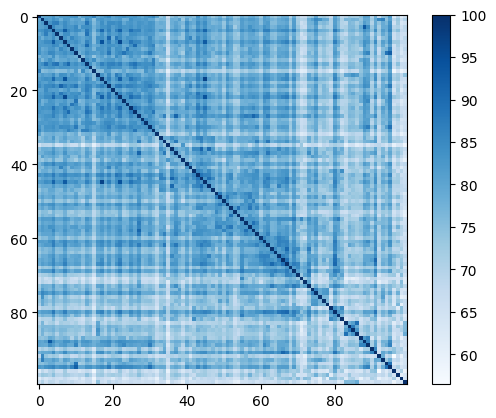

In [14]:
clip_sim = cosine_similarity(grouped_clip_class_features, grouped_clip_class_features)*100
plt.imshow(clip_sim, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
# plt.savefig('test.jpg')